In [3]:
#라이브러리 로드
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os
import random
import matplotlib.pyplot as plt
import shutil

from keras.preprocessing.image import load_img 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster # 지정한 클러스터 자르기

In [207]:
data_dir = 'saves/' #1.데이터 불러오기 - csv 데이터 폴더 디렉토리
image_dir = "images/" #5.이미지 로드 및 그룹화 - 이미지 폴더 디렉토리
result_dir = "recommand/" #7. 데이터 저장 - 데이터 저장 디렉토리
pca_threshold = 0.99 #3. PCA - 적합한 차원 수 찾기

In [7]:
# this list holds all the image filename
file_names = []
data = []

with os.scandir(data_dir) as files:
    for file in files:
        # 모든 csv 파일 읽어오기
        if file.name.endswith('csv'):
            file_names.append(data_dir + file.name)
            
for file in file_names:
    now = pd.read_csv(file, header = 0, index_col = 0).to_numpy()
    data.append(now)

In [137]:
def flatten_with_rgb(data):
    div = 0.20001
    flt_data = []
    
    for feature in data: 
        r = (feature[:,0] / div).astype(int)
        g = (feature[:,1] / div).astype(int)
        b = (feature[:,2] / div).astype(int)
        tar = g * 25 + r * 5 + b
        
        new_row = np.zeros(125)
        for num, val in zip(tar, data[0][:, 6]):
            new_row[num] += val #+ (0.01 * num)
            
        flt_data.append(new_row)
    return flt_data

In [139]:
flt_data = flatten_with_rgb(data)

In [140]:
clusters = linkage(y=flt_data, method='complete', metric='euclidean')

In [141]:
clusters.shape

(5408, 4)

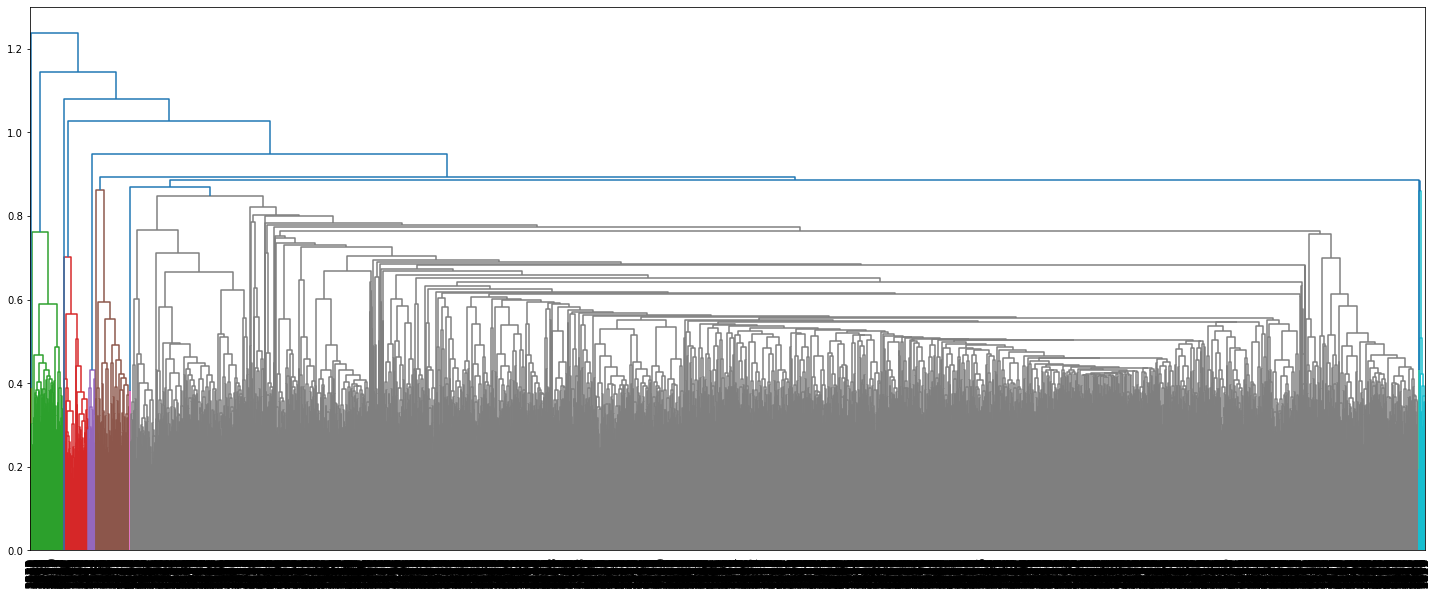

In [15]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
# leaf_rotation=90 : 글자 각도
# leaf_font_size=20 : 글자 사이즈
plt.show() 

In [151]:
cut_tree = fcluster(clusters, t=0.8, criterion='distance')
cut_tree # prediction

array([35, 34, 34, ..., 34, 37, 30], dtype=int32)

In [152]:
np.unique(cut_tree)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37], dtype=int32)

In [153]:
image_file_names = []

for file in file_names:
    image_file_names.append(image_dir + file.rsplit('.')[0].rsplit('/')[1] + '.jpg')

In [154]:
def grouping_by_clusters(image_file_names, labels):
    groups = {}
    for file, cluster in zip(image_file_names, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [155]:
groups = grouping_by_clusters(image_file_names, cut_tree)

In [118]:
def view_cluster(groups, cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 24:
        print(f"Clipping cluster size from {len(files)} to 24")
        files = files[:24]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(8, 8,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

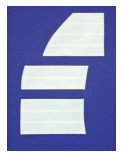

In [119]:
view_cluster(groups, 8)

In [156]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [157]:
def save_data(groups, result_dir):
    for clusters, files in groups.items():
        createFolder(result_dir + str(clusters))
        for file in files:
            shutil.copyfile(file, result_dir + str(clusters) + '/' + file.rsplit('/')[1])

In [158]:
save_data(groups, result_dir)